In [1]:
import pandas as pd
import nltk
from libs.cleaning import *
from libs.preprocess import *
from matplotlib import pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

nltk_download()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
DATA_PATH = "../data"
sent_names = ["/tweets_neg_clean.csv","/tweets_pos_clean.csv"]
dfs = list(map(lambda x: pd.read_csv(DATA_PATH + x), sent_names))
dfs.append(pd.read_csv(DATA_PATH + "/tweets_clean.csv"))
tweets = pd.concat(dfs, ignore_index=True)[["Tweet"]]
tweets["telecom"] = 0

dfs = list()
for raiz, directorios, archivos in os.walk(DATA_PATH+"/train_ift"):
    for archivo in archivos:
        dfs.append(pd.read_excel(os.path.join(raiz, archivo).replace("\\", "/"), header=None))
tweets2 = pd.concat(dfs, ignore_index=True)
tweets2.columns = ['User', 'Tweet', 'Link', 'Date']
#Muestra de tweets2
tweets2 = tweets2[["Tweet"]]
tweets2["telecom"] = 1

#tweets = pd.concat([tweets, tweets2], ignore_index=True)


# Limpieza

In [3]:
tweets["RT"] = tweets["Tweet"].apply(lambda x: 1 if x.startswith("RT") else 0)
tweets2["RT"] = tweets["Tweet"].apply(lambda x: 1 if x.startswith("RT") else 0)
tweets.head()

,Tweet,telecom,RT
0,HOY NO COMULGUE :( Eso neta me hace sentir mal...,0,0
1,20. Por tus gustos siempre me has caído bien p...,0,0
2,QUE LAMENTABLE MI PROVINCIA :( https://t.co/w...,0,0
3,"?Papel. ?Tijeras, te gané. ?¡Papel! ?Tijeras, ...",0,0
4,La primera ves que me pasa eso y espero que se...,0,0


In [4]:
tweets["Cleaned"] = limpieza_total(tweets["Tweet"])
tweets["Cleaned"] = tweets["Cleaned"].apply(lambda x: stem_text(x)) # Stemming o lematización

tweets2["Cleaned"] = limpieza_total(tweets2["Tweet"])
tweets2["Cleaned"] = tweets2["Cleaned"].apply(lambda x: stem_text(x)) # Stemming o lematización

In [5]:
tweets["len"] = tweets["Cleaned"].apply(lambda x: len(x.split()))
tweets2["len"] = tweets2["Cleaned"].apply(lambda x: len(x.split()))

In [6]:
tweets = tweets[tweets["RT"] == 0][tweets["Cleaned"]!=""][tweets["len"]>=3].sample(frac=0.40, random_state=42)
tweets2 = tweets2[tweets2["RT"] == 0][tweets2["Cleaned"]!=""][tweets2["len"]>=3].sample(n=tweets.shape[0], random_state=42)
tweets = pd.concat([tweets, tweets2], ignore_index=True)
tweets["telecom"].groupby(tweets["telecom"]).count()

telecom
0    48065
1    48065
Name: telecom, dtype: int64

# Análisis

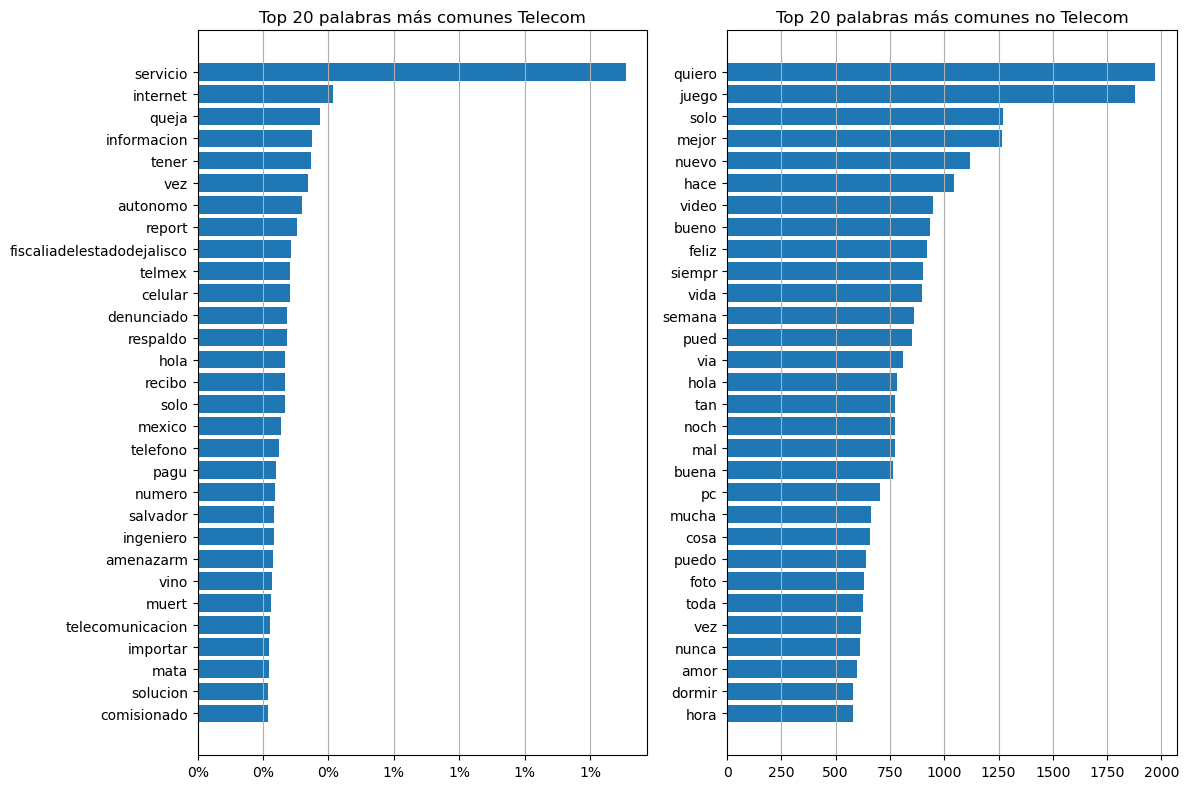

In [9]:
from matplotlib.ticker import FuncFormatter
# Función para formatear los valores como porcentaje
formatter = FuncFormatter(lambda x, pos: f'{x:.0%}')

#Top 20 words en cada categoría
top_words = pd.Series(count_words(tweets.Cleaned.str.split())).sort_values(ascending=False)
top_words_per = top_words / top_words.sum()

top_words_pos = pd.Series(count_words(tweets[tweets["telecom"]==1].Cleaned.str.split())).sort_values(ascending=False)
top_words_neg = pd.Series(count_words(tweets[tweets["telecom"]==0].Cleaned.str.split())).sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

axes[0].grid(axis='x')  # Añadir cuadrícula solo en el eje x
# Invertir el orden de las palabras y los valores en el eje y para la primera gráfica
axes[0].barh(top_words_pos.index[:30], top_words_per.values[:30])
axes[0].set_title("Top 20 palabras más comunes Telecom")
axes[0].invert_yaxis()  # Voltear en espejo
axes[0].xaxis.set_major_formatter(formatter)  # Formatear eje x como porcentaje

axes[1].grid(axis='x')  # Añadir cuadrícula solo en el eje x
# Invertir el orden de las palabras y los valores en el eje y para la segunda gráfica
axes[1].barh(top_words_neg.index[:30][::-1], top_words_neg.values[:30][::-1])
axes[1].set_title("Top 20 palabras más comunes no Telecom")
#axes[1].xaxis.set_major_formatter(formatter)  # Formatear eje x como porcentaje

plt.tight_layout()
plt.show()

# Clustering

## Tokenize

In [10]:
tweets["Token"] = tweets.Cleaned.str.split()

## Train test split

In [11]:
#importamos train test split
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(tweets["Cleaned"], tweets["telecom"], test_size=0.2, random_state=42)

## Embeddings

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
w2v = TfidfVectorizer(min_df=10)
w2v.fit(X_train)

TfidfVectorizer(min_df=10)

In [15]:
X_train_emb = w2v.transform(X_train)

X_test_emb = w2v.transform(X_test)

In [16]:
#Numero de palabras aprendidas
len(w2v.vocabulary_)

7399

## T-SNE
(Para pre visualizar los datos)

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=2, random_state=42,
             n_iter=2000, perplexity=30, init='random',
               metric='cosine', n_jobs=-1)
# X_train_emb = np.vstack(X_train_emb.to_numpy())
# X_test_emb = np.vstack(X_test_emb.to_numpy())
tsne_cord = tsne.fit_transform(X_train_emb)

## Pre visualización

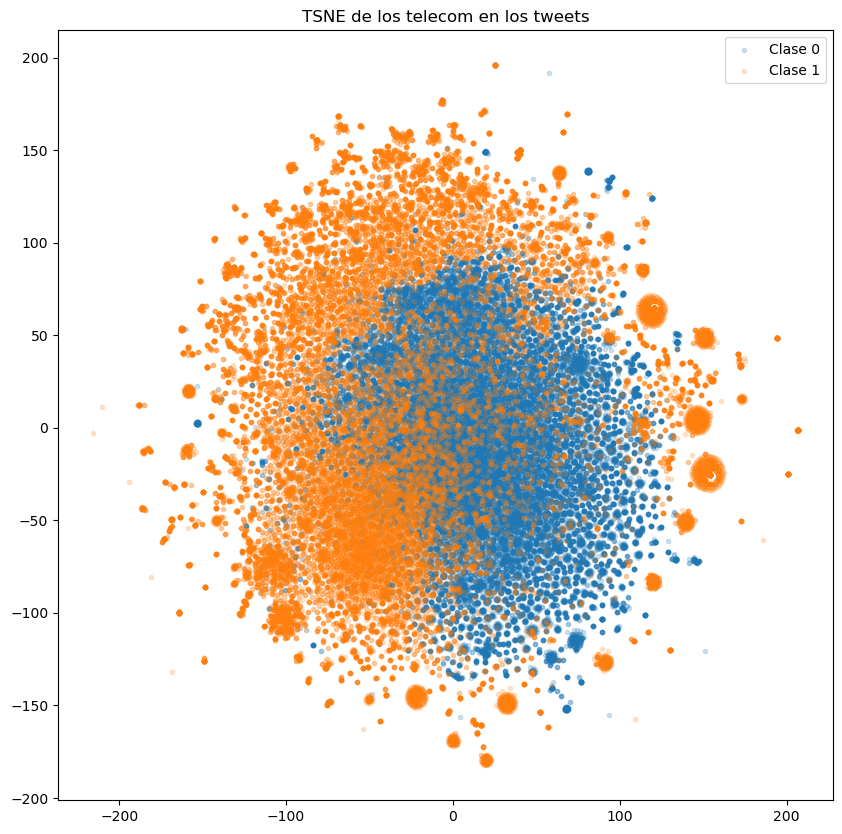

In [23]:
def plot_tsne(tsne_cord, y_train=y_train):
    pre_vis = np.vstack(tsne_cord)
    fig = plt.figure(figsize=(10, 10))
    for clase in np.unique(y_train):
        indices = np.where(y_train == clase)
        plt.scatter(tsne_cord[indices, 0], tsne_cord[indices, 1],
                     label=f'Clase {clase}', marker='.', alpha=0.2)
    plt.title("TSNE de los telecom en los tweets")
    plt.legend()
    plt.show()

plot_tsne(tsne_cord=tsne_cord, y_train=y_train)

# Clasificador

In [24]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

In [21]:
svc = SVC()

# SVC

In [22]:
#SVC
param_svc = {
    'C': [0.1, 1, 10],
}
GS_svc = GridSearchCV(svc, param_svc, cv=5, n_jobs=-1)
GS_svc.fit(X_train_emb, y_train)
print(GS_svc.best_params_)
y_pred = GS_svc.predict(X_test_emb)
print("Reporte de prueba")
print(classification_report(y_test, y_pred))
print("Reporte de entrenamiento")
y_pred = GS_svc.predict(X_train_emb)
print(classification_report(y_train, y_pred))

{'C': 10}
Reporte de prueba
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      9630
           1       0.98      0.96      0.97      9596

    accuracy                           0.97     19226
   macro avg       0.97      0.97      0.97     19226
weighted avg       0.97      0.97      0.97     19226

Reporte de entrenamiento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38435
           1       1.00      1.00      1.00     38469

    accuracy                           1.00     76904
   macro avg       1.00      1.00      1.00     76904
weighted avg       1.00      1.00      1.00     76904



# Regresión logistica

In [26]:
lr = LogisticRegression()
#Logistic Regression
#Parametros de logistic regression
param_lr = {
    'C': [0.1, 1, 10]
}
GS_lr = GridSearchCV(lr, param_lr, cv=5, n_jobs=-1)
GS_lr.fit(X_train_emb, y_train)
print(GS_lr.best_params_)
y_pred = GS_lr.predict(X_test_emb)
print("Reporte de prueba")
print(classification_report(y_test, y_pred))
print("Reporte de entrenamiento")
y_pred = GS_lr.predict(X_train_emb)
print(classification_report(y_train, y_pred))

{'C': 10}
Reporte de prueba
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      9630
           1       0.97      0.95      0.96      9596

    accuracy                           0.96     19226
   macro avg       0.96      0.96      0.96     19226
weighted avg       0.96      0.96      0.96     19226

Reporte de entrenamiento
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     38435
           1       0.99      0.97      0.98     38469

    accuracy                           0.98     76904
   macro avg       0.98      0.98      0.98     76904
weighted avg       0.98      0.98      0.98     76904



**Para este caso nos uqedamos con Regrsión logística por cuestión de tiempo y coste de procesamiento**